# Otimização dos hiperparâmetros

Notebook que realiza a otimização e salva os melhores hiperparâmetros dos 3 modelos.

In [1]:
import sys
sys.path.append('..')
import pickle
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice
import matplotlib.pyplot as plt
import torch
from src.data.data import LoFiDataset
from src.optimization.optuna_vae import objective

/home/diego/miniconda3/envs/amaprob/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_to_save = r"../data/processed/best_hyperparams.pkl"
n_trials = 1
#models = ["dense", "conv", "lstm"]
models = ["dense", "lstm"]
n_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


Total de arquivos: 2611


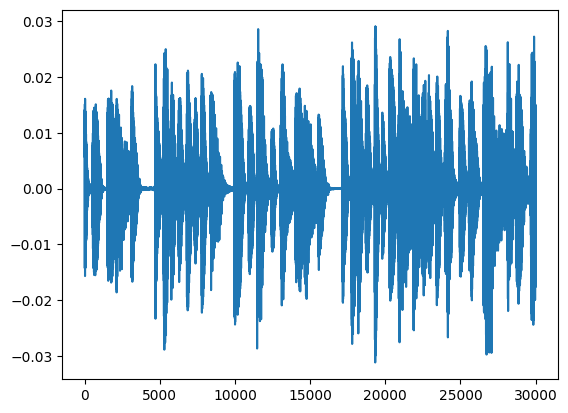

In [3]:
dataset = LoFiDataset('../data/raw')
print(f"Total de arquivos: {len(dataset)}")
plt.plot(dataset[30])
plt.show()

## Inicialização do optuna

In [15]:
studies = {model:None for model in models}
for model_name in studies.keys():
    print(f"Otimização do modelo {model_name} iniciada!")
    studies[model_name] = optuna.create_study(direction="minimize")
    studies[model_name].optimize(lambda trial: objective(trial, model_name, n_epochs, dataset, device), n_trials=n_trials)
    pruned_trials = [t for t in studies[model_name].trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in studies[model_name].trials if t.state == optuna.trial.TrialState.COMPLETE]
    print(f"Número de trials finalizadas: {len(studies[model_name].trials)}")
    print(f"Número de trials podadas: {len(pruned_trials)}")
    print(f"Número de trials completas: {len(complete_trials)}")
    print(f"Otimização do modelo {model_name} finalizada!")

[I 2025-02-18 16:34:47,171] A new study created in memory with name: no-name-2bc699d3-ed46-4a5d-a319-0c96db7d7a69


Otimização do modelo dense iniciada!


[I 2025-02-18 16:35:27,666] Trial 0 finished with value: 0.0081127705737291 and parameters: {'num_layers': 2, 'latent_dim': 10, 'input_neurons': 750, 'output_neurons': 200}. Best is trial 0 with value: 0.0081127705737291.
[I 2025-02-18 16:35:27,668] A new study created in memory with name: no-name-dd66433c-3cf6-4bf6-b603-1be2d5c06695


	[TRAINING] Epoch 1 	Average train Loss:  0.017623977040674425 	Average test Loss:  0.0081127705737291
Número de trials finalizadas: 1
Número de trials podadas: 0
Número de trials completas: 1
Otimização do modelo dense finalizada!
Otimização do modelo lstm iniciada!


[I 2025-02-18 16:36:11,164] Trial 0 finished with value: 0.008493795840288787 and parameters: {'num_layers': 1, 'latent_dim': 2, 'output_neurons': 200, 'middle_ground': 150}. Best is trial 0 with value: 0.008493795840288787.


	[TRAINING] Epoch 1 	Average train Loss:  0.02017492304245631 	Average test Loss:  0.008493795840288787
Número de trials finalizadas: 1
Número de trials podadas: 0
Número de trials completas: 1
Otimização do modelo lstm finalizada!


## Melhores hiperparâmetros

### Dense

In [22]:
studies["dense"].best_params

{'num_layers': 2,
 'latent_dim': 10,
 'input_neurons': 750,
 'output_neurons': 200}

In [18]:
#plot_optimization_history(study)

In [17]:
#plot_parallel_coordinate(study)

In [16]:
#plot_param_importances(study)

### Conv

### LSTM

In [21]:
studies["lstm"].best_params

{'num_layers': 1, 'latent_dim': 2, 'output_neurons': 200, 'middle_ground': 150}

### Salvando os dicts dos hiperparâmetros

In [33]:
best_params = {model:studies[model].best_params for model in models}

In [36]:
with open(path_to_save, "wb") as f:
    pickle.dump(best_params, f)